In [1]:
# Import Libraries
import rawpy as rp
import cv2
import numpy as np
import pandas as pd

import PIL
from PIL import Image
from PIL.ExifTags import TAGS
import exiftool
import notebook

import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import RAW image of Labsphere Reflectance Standard
raw = rp.imread('IMG_20240227_113829.dng')

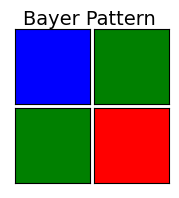

In [3]:
# As we are only interested in the red channel - this snippet determines the camera filter pattern so we can extract 
# only the red channel digital number

bayer = raw.raw_image
bayer_pattern = ''.join(np.array(list((raw.color_desc).decode('ascii')))[raw.raw_pattern].flatten())
color = bayer_pattern.lower()

plt.figure(figsize=(2,2))
gs1 = gridspec.GridSpec(2,2)
gs1.update(wspace=0.05, hspace=0.05)
plt.suptitle('Bayer Pattern', fontsize=14)

for i in range(4):
    ax1 = plt.subplot(gs1[i])
    ax1.set_facecolor(color[i])
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
plt.show()    

In [5]:
# The image above tells us the red channel position.  From here, we use the following conditional to extract red and green 
# channels separately = []
red = []

for i in range(bayer.shape[0]):
    if i % 2 != 0:
        red.append(bayer[i][1::2])

green1, green2 = [],[]

for i in range(bayer.shape[0]):
    if i % 2 == 0:
        green1.append(bayer[i][1::2])
    else:
        green2.append(bayer[i][0::2])

In [6]:
# Post pixel pushing to create new image capable files after extracting
red = np.concatenate(red, axis=0)
red.shape = (int(bayer.shape[0]/2), int(bayer.shape[1]/2))

green1 = np.concatenate(green1, axis=0)
green1.shape = (int(bayer.shape[0]/2), int(bayer.shape[1]/2))

green2 = np.concatenate(green2, axis=0)
green2.shape = (int(bayer.shape[0]/2), int(bayer.shape[1]/2))

green = (green1+green2)/2
green = green.astype(int)

### Note - Given the high reflectivity of the Labsphere standard, we are expecting the red channel to saturate, particularly since we are using a red LED to illuminate the sample.  So, we will actually test our uniformity using the green channel which we know will have poorer spectral overlap with the light reflecting off of the sample.

In [7]:
# Selecting the region of interest on the monochrome image
w1, w2 = 400, 400
x1, y1, wx1, wy1 = 790, 550, w1, w2

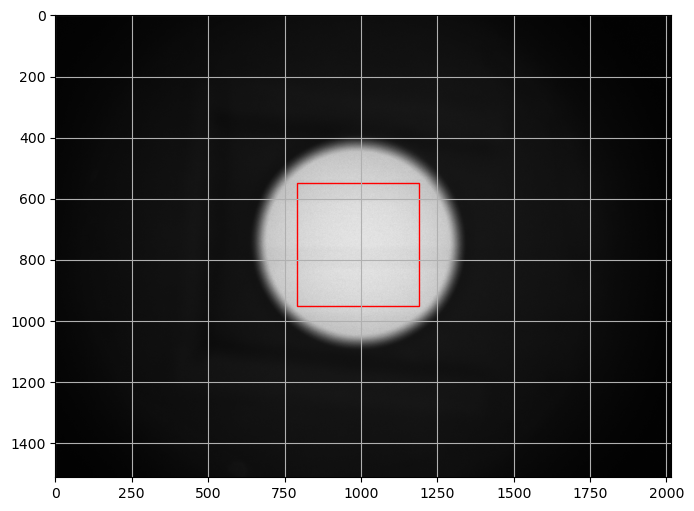

In [8]:
# Plots the monochrome image and highlights the test region
fig, ax = plt.subplots(figsize = (8, 6))
ax.imshow(green,cmap = 'gray')
rect1 = patches.Rectangle((x1, y1), wx1, wy1, linewidth = 1, edgecolor = 'red', facecolor = 'none')
ax.add_patch(rect1)
plt.grid()
plt.show()

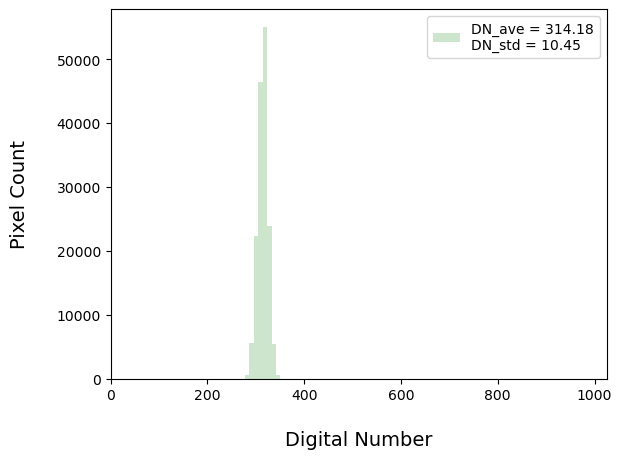

In [9]:
# This is a test to verify that the data is not above the camera's saturation point.  We are targeting a distribution with digital 
# numbers somewhere between 300 to 700.  If greater than 700, consider pulling from the blue channel
def hist(img):
    plt.hist(img.flatten(), bins = 10, color = 'g', alpha = 0.2, label = 'DN_ave = '+str(round(np.average(img), 2))+'\nDN_std = '+str(round(np.std(img), 2)))
    plt.xlabel('\nDigital Number', fontsize = 14)
    plt.ylabel('Pixel Count\n', fontsize = 14)
    plt.xlim(0, 1025)
    plt.legend()
    return plt.show()

hist(green[y1:y1+wy1, x1:x1+wx1])

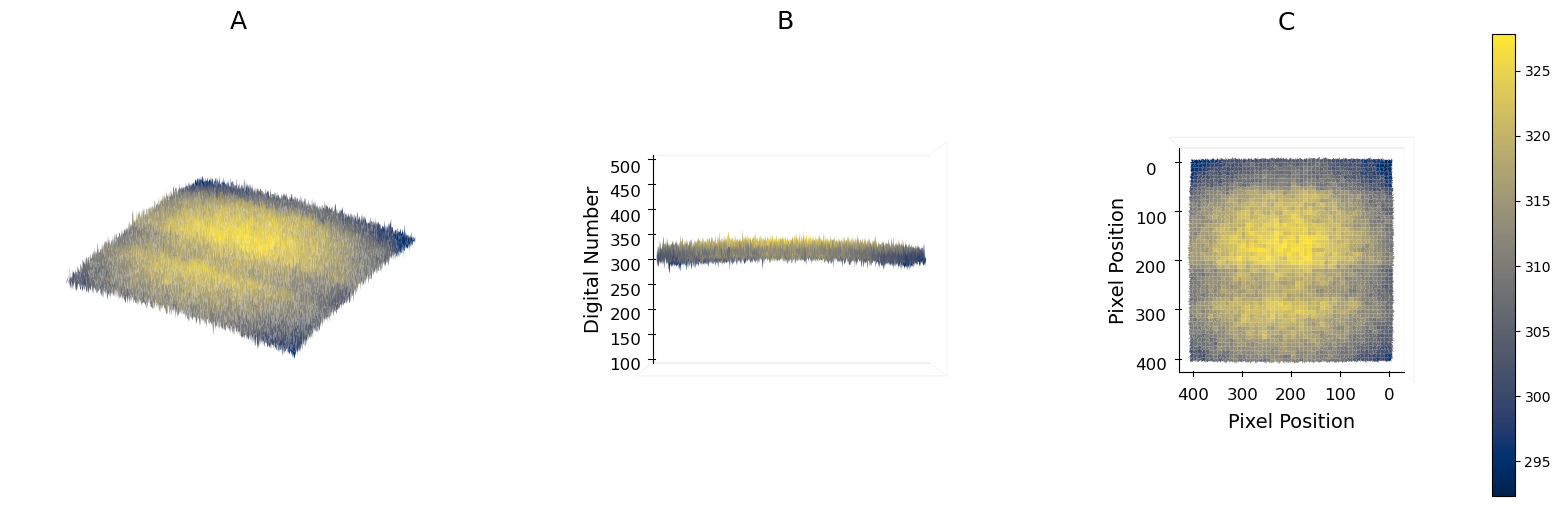

In [33]:
#Plot Uniformity Graphs
im_temp = green[y1:y1+wy1, x1:x1+wx1]
x = np.arange(0, im_temp.shape[1])
y = np.arange(0, im_temp.shape[0])
X,Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(20, 6))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.view_init(elev=30, azim=120)
ax.plot_surface(X, Y, im_temp, cmap='cividis')
ax.set_zlim(100, 500)
ax.set_zlabel('Digital Number')
ax.set_axis_off()
ax.set_title('A', fontsize=18)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.tick_params(axis='x', labelsize=12, pad=2)
ax.tick_params(axis='z', labelsize=12, pad=10)
ax.plot_surface(X, Y, im_temp, cmap='cividis')
ax.set_zlim(100, 500)
ax.set_zlabel('Digital Number\n\n', fontsize=14)
ax.set_title('B', fontsize=18)
ax.w_xaxis.line.set_lw(0.)
ax.set_xticks([])
ax.w_yaxis.line.set_lw(0.)
ax.set_yticks([])
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(0, 90)

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.tick_params(axis='x', labelsize=12, pad=2)
ax.tick_params(axis='y', labelsize=12, pad=10)
p = ax.plot_surface(X, Y, im_temp, cmap='cividis')
ax.set_title('C', pad=38, fontsize=18)
ax.set_xlabel('\nPixel Position', fontsize=14)
ax.set_ylabel('Pixel Position\n\n', fontsize=14)
fig.colorbar(p, ax=ax)
ax.set_zticks([])
ax.w_zaxis.line.set_lw(0.)
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(90, 90)

plt.savefig('uniformity.png', bbox_inches='tight', dpi=600)
plt.show()
